# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [94]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('data/Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('data/AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(f'Data contains {azdias.shape[0]} rows and {azdias.shape[1]} columns')  # Shape

Data contains 891221 rows and 85 columns


In [4]:
azdias.sample(10)  # Look at sample of rows

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
495303,-1,3,2,6.0,3,2,4,1,2,2,...,3.0,3.0,1.0,0.0,1.0,3.0,4.0,4.0,8.0,5.0
158319,-1,1,1,3.0,1,5,2,5,5,5,...,3.0,3.0,0.0,0.0,1.0,2.0,3.0,4.0,6.0,3.0
64338,-1,4,2,1.0,3,1,5,2,1,5,...,4.0,2.0,1.0,1.0,1.0,4.0,5.0,3.0,3.0,3.0
876343,-1,2,2,5.0,2,3,4,2,3,4,...,1.0,4.0,3.0,1.0,3.0,4.0,3.0,4.0,7.0,5.0
507404,2,4,2,2.0,5,1,5,1,1,3,...,3.0,2.0,2.0,1.0,1.0,3.0,3.0,3.0,6.0,4.0
536919,-1,3,2,4.0,2,2,4,4,3,3,...,2.0,4.0,2.0,1.0,2.0,3.0,2.0,2.0,5.0,2.0
803266,-1,1,1,4.0,1,5,3,5,3,4,...,1.0,4.0,3.0,1.0,5.0,4.0,3.0,3.0,5.0,2.0
386028,-1,4,1,3.0,2,4,1,3,4,4,...,1.0,2.0,3.0,2.0,5.0,5.0,2.0,4.0,9.0,3.0
862615,-1,1,2,4.0,2,3,4,4,2,3,...,4.0,1.0,0.0,0.0,1.0,2.0,3.0,2.0,1.0,1.0
188589,-1,1,1,4.0,3,4,3,5,5,3,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,3.0,5.0,3.0


In [5]:
print(azdias.dtypes.unique())  # Determine what data types are used

[dtype('int64') dtype('float64') dtype('O')]


Note that there is an general object type `O`. Most often this represents string data type, but let's clarify exactly what python type corresponds to these objects

In [6]:
azdias.select_dtypes(include='O').head()

,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015
0,NaN,NaN,NaN,NaN
1,W,8,8A,51
2,W,4,4C,24
3,W,2,2A,12
4,W,6,6B,43


In [7]:
# Determine python data type corresponding the the pandas 'O' type in the data set
for col in azdias.select_dtypes(include='O').columns:
    print(f'Column {col}: {type(azdias[col].iloc[1])} type')

Column OST_WEST_KZ: <class 'str'> type
Column CAMEO_DEUG_2015: <class 'str'> type
Column CAMEO_DEU_2015: <class 'str'> type
Column CAMEO_INTL_2015: <class 'str'> type


We have confirmed that pandas `O` type is Python `str` type.  
  
Now let's look at the info features dictionary to get a better understanding of what kinds of data is contained in the dataset:

In [8]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


We can see that `feat_info` dictionary contains column names and the explanations for the type of data stored and how missing values are encoded for each of these columns. Additionally, there is `information_level` which we'll get back to later.  
  
Let's look at the types of data in our dataset:

In [9]:
data_types = ', '.join(feat_info['type'].unique())
print(f'Azdias dataset contains the following feature types: {data_types}')

Azdias dataset contains the following feature types: categorical, ordinal, numeric, mixed, interval


Note that although original data types are already encoded as *int*, *float*, or *str*, we will likely have to make additional data transformations for at least categorical and mixed features of the set.

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

First lets see how many values are already **recorded** as missing:

In [10]:
# Identify missing or unknown data values in the original data set
raw_original_missing_per_column = azdias.isna().sum()  # recorded as missing

# With such large number of rows it is easier to visualize percentage of missing data
percent_original_missing_per_column = round(azdias.isna().sum() / azdias.shape[0] * 100, 2)

print(f'Original dataset contains {raw_original_missing_per_column.sum()} values encoded as NAN, '
      f'corresponding to {100 * azdias.isna().sum().sum() / (azdias.shape[0] * azdias.shape[1]):.2f}'
      f'% of all values.')

# Column with this most missing values
print(f'Column with highest percentage of missing values is {percent_original_missing_per_column.idxmax()} '
      f'with {percent_original_missing_per_column.max()}% missing.')

Original dataset contains 4896838 values encoded as NAN, corresponding to 6.46% of all values.
Column with highest percentage of missing values is KK_KUNDENTYP with 65.6% missing.


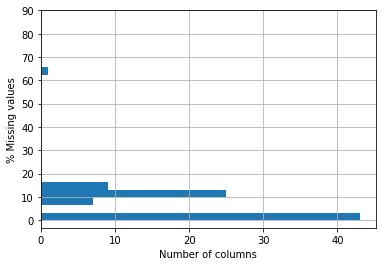

In [11]:
ax0 = percent_original_missing_per_column.hist(bins=20, orientation='horizontal')
ax0.set_yticks(np.arange(0, 100, 10))
ax0.set_xlabel('Number of columns')
ax0.set_ylabel('% Missing values');

We can see that about half of the columns already contain over 10% of missing data and highest missing values column, `KK_KUNDENTYP`, is missing over 65% of values. Moreover, from our `feat_info` dictionary, we know that some missing or unknown values are encoded differently than NaN. Let's find these additional missing values, noting that `feat_info`.The `missing_or_unknown` column values are string representations of lists (see below) and, therefore, must be appropriately parsed.

In [12]:
feat_info.missing_or_unknown.unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [13]:
def encode_nan(df, feat_info):
    """Returns pd.DataFrame with standard encoded missing values. Converts custom encoded missing value
       representations for each feature in input df to np.nan using feat_info summary.
    
    Args:
        df (pd.DataFrame): input dataframe with custom encoded missing values
        feat_info (pd.DataFrame): feature summary that contains the following columns/information:
                                  - attribute (str): df column name
                                  - missing_or_unknown (str): information on how missing values are encoded in each col
    
    Returns:
        df_out (pd.DataFrame): output dataframe with standard encoded missing values as np.nan
    """
    # Create new df containing invalid items encoded as NaN
    df_out = pd.DataFrame()

    # loop through data columns and replace appropriate invalid items with NaN
    for col in df:

        # Retrieve how invalid data is originally encoded in the current column using **feat_info**
        encoding = feat_info.loc[feat_info.attribute == col, 'missing_or_unknown'].iloc[0]

        # parse encoding and convert it into a list of strings
        encoding = encoding.strip('][').split(',')  # encoding = [str]

        # generate list of invalid values of appropriate type for current col 
        invalid = [int(x) if df[col].dtypes == np.int64  # int64 columns
                   else float(x) if df[col].dtypes == np.float64  # float64 columns
                   else x for x in encoding if x]  # 'O'(str) columns if non-empty

        # note: it's probably overkill to distinguish between float and int above when
        #       doing comparison in pd.DataFrame.replace() below in this particular case,
        #       but it is probably safer for more general use cases

        # replace invalid items
        if invalid:
            df_out[col] = df[col].replace(invalid, [np.nan] * len(invalid))
        else:
            df_out[col] = df[col]
    
    return df_out
        

In [14]:
df = encode_nan(df=azdias, feat_info=feat_info)  # encode azdias

We will use the `encode_nan()` function to encode missing values both for the census as well as customer data subsets later in our analysis.

In [15]:
n_missing = df.isna().sum().sum()
print(f'Total number of missing values in original dataset is {n_missing}, '
      f'corresponding to {100 * n_missing / (df.shape[0] * df.shape[1]):.2f}% of all values.')

Total number of missing values in original dataset is 8373929, corresponding to 11.05% of all values.


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

We examine the missing data as percentage of rows with missing values for each column:

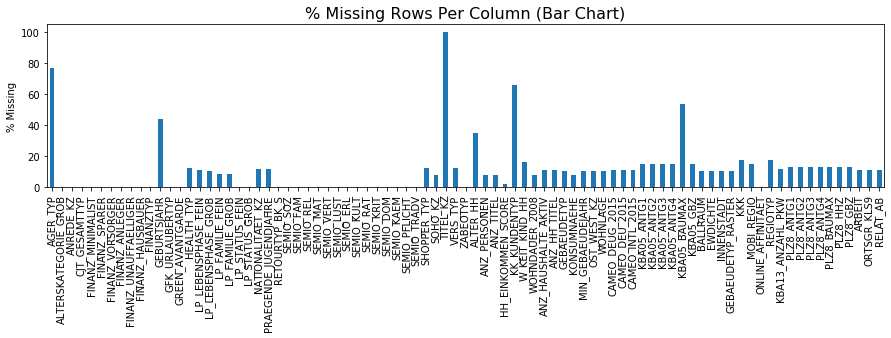

In [16]:
# Examine % of missing values in each column
percent_missing_per_column = df.isna().sum() / df.shape[0] * 100 # recorded as missing percent of total
ax1 = percent_missing_per_column.plot.bar(figsize=(15,3))
ax1.set_ylabel('% Missing')
ax1.set_title('% Missing Rows Per Column (Bar Chart)', fontsize=16);

Looking at the plot of percentage of missing data by column, we find that several columns have more than 50% of rows with missing values, with one column almost entirely missing data (99.75% missing!). Lets look at the distribution of the missing values by column and search for outliers. A boxplot would be a good plot type for this task:

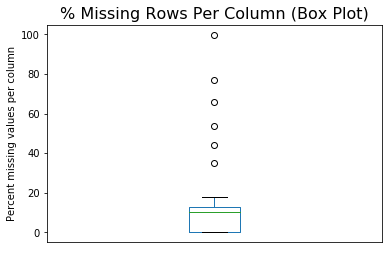

In [17]:
# Investigate patterns in the amount of missing data in each column
ax2, bp = percent_missing_per_column.plot.box(return_type='both')

# Format axis
x_axis = ax2.axes.get_xaxis()
x_axis.set_visible(False)
ax2.set_title('% Missing Rows Per Column (Box Plot)', fontsize=16)
ax2.set(ylabel='Percent missing values per column');

In [18]:
median_missing_per_column = [median.get_ydata() for median in bp["medians"]][0][0]
print(f'Median percent of missing values per column is {median_missing_per_column:.2f}%')

Median percent of missing values per column is 10.45%


The boxplot shows six outlier columns with large amount of missing row data.

In [19]:
# Identify the outlier columns by percent of missing values
# get outlier values from pd.boxplot
outlier_missing_per_column = [flier.get_ydata() for flier in bp["fliers"]]
outlier_columns = percent_missing_per_column[
            percent_missing_per_column.isin(outlier_missing_per_column[0])]

For the purpose of the analysis below we will drop these columns with large number of missing row values from our dataset.

In [20]:
# Remove outlier columns from the dataset
drop_columns = outlier_columns.index.tolist()
print(f'Dropping columns with outlier amount of missing data:\n{outlier_columns}')
df = df.drop(columns=drop_columns)  # drop outlier columns

Dropping columns with outlier amount of missing data:
AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64


In [21]:
n_missing = df.isna().sum().sum()
print(f'Total number of missing values after outlier column drop is {n_missing}, '
      f'corresponding to {100 * n_missing / (df.shape[0] * df.shape[1]):.2f}% of all values.')

Total number of missing values after outlier column drop is 5035304, corresponding to 7.15% of all values.


Dropping outlier columns reduced the number of missing values from ~11% to ~7% of all values.

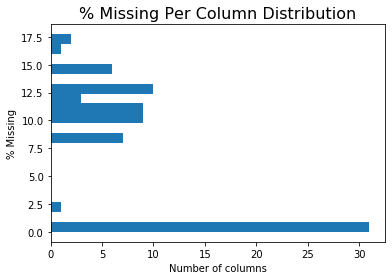

In [22]:
# Examine distribution of missing data over the remaining columns
ax3 = percent_missing_per_column[percent_missing_per_column < 20].hist(bins=20, grid=False,
                                                                       orientation='horizontal')
ax3.set(xlabel='Number of columns', ylabel='% Missing')
ax3.set_title('% Missing Per Column Distribution', fontsize=16);

We can visualize the location of the missing values in our data set using a heat map.

In [23]:
missing_df = df.isnull()  # mapping of missing value location over the dataset

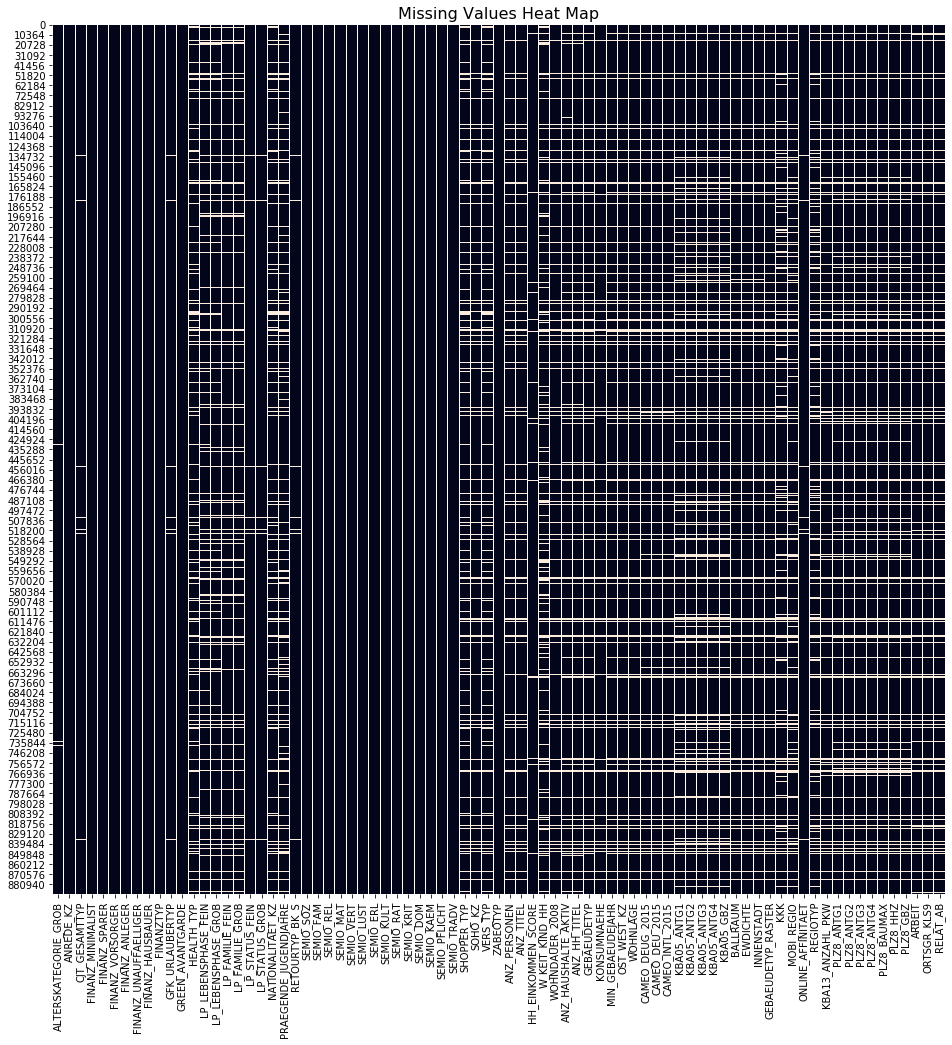

In [24]:
plt.figure(figsize=(16, 16))
ax4 = sns.heatmap(missing_df, cbar=False)
ax4.set_title('Missing Values Heat Map', fontsize=16);

We can clearly see column/row-wise patches of missing data in our dataset, suggesting a relationship between our features/columns in terms of missing information. We can check the strength of this relationship by examining the correlation matrix of `missing_df`:

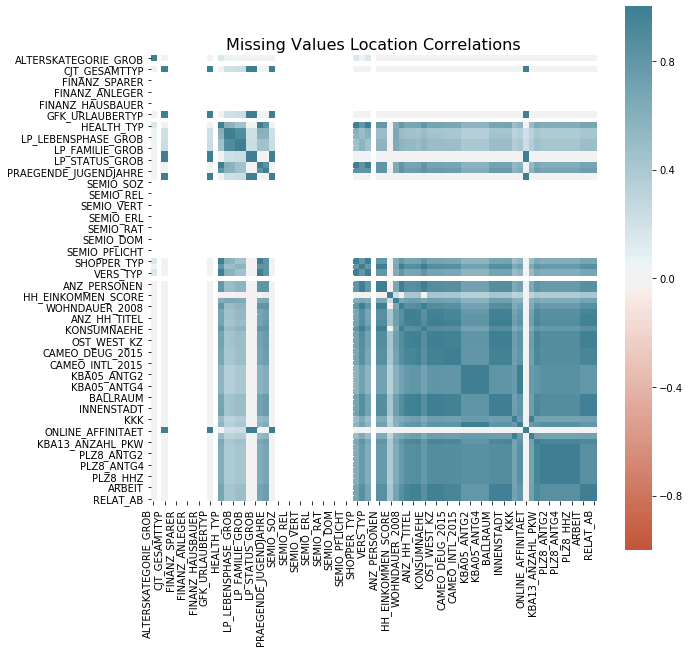

In [25]:
fig, ax5 = plt.subplots(figsize=(10,10))  
ax5 = sns.heatmap(missing_df.corr(), vmin=-1, vmax=1, center=0,
                  cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=90, horizontalalignment='right')
ax5.set_title('Missing Values Location Correlations', fontsize=16);

From the correlation plot above, we can say that there is a strong correlation between some columns in terms of the number of missing values, i.e. there is a high probability that if a value for a given row is missing in column A it will also be missing in column B. For example, if for a given row a value in column `RELAT_AB` is missing, it is also likely missing in columns `INNENSTADT`, `ANZ_HH_TITEL`, `CAMEO_INTL_2015`, etc., and vice versa.

#### Discussion 1.1.2: Assess Missing Data in Each Column

##### Summary:
The unprocessed original dataset contains **8,373,929** missing values (**11.05%** of all values) with about half of the features with over **10%** of missing data with the highest number of missing values column, `KK_KUNDENTYP`, missing over **65%** of values. When the dataset was further processed to properly encode the missing values per documentation in `AZDIAS_Feature_Summary.csv`, it was found that the median percent of missing values per columns is **10.45%** with __6__ outlier columns having over **30%** of rows with missing data. The outlier columns were dropped and column names are stored in the `drop_columns` variable to be used for cleaning both the **AZDIAS** and the **CUSTOMER** datasets. The cleaned-up data contains around **30** columns with less than **1%** of missing values with the majority of the remaining columns missing between **8 and 18%** of values.

Additionally, it was observed that there is a strong correlations between some sets of columns in terms of the number of missing values for a given row (see "Missing Values Location Correlations" plot and discussion above). The exploration of missing row data is below.

##### Data Selection and Cleaning:
- Missing value encoding: Using `missing_or_uknown` information for each column in `feat_info` dictionary, re-encoded **3,477,091** missing values as `np.nan`
- Data Subset: **removed columns** `AGER_TYP`, `GEBURTSJAHR`, `TITEL_KZ`, `ALTER_HH`, `KK_KUNDENTYP`, `KBA05_BAUMAX`. Dropped column names are stored in `drop_columns`.
  

##### Output:
- Renamed working dataframe with removed missing value outlier columns as `df`
- Data shape: **891,221** rows and **79** columns with total **5,035,304** (7.15%) missing values encoded as np.`nan`

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [26]:
# How much data is missing in each row of the dataset?
number_missing_per_row = df.isna().sum(axis=1) # recorded as missing percent of total

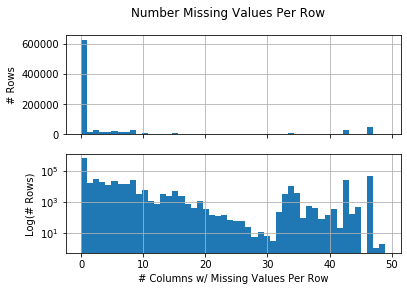

In [27]:
fig, (ax6, ax7) = plt.subplots(2)
fig.suptitle('Number Missing Values Per Row')

number_missing_per_row.hist(bins=50, ax=ax6)
ax6.set_ylabel('# Rows');
ax6.set_xticklabels([])

number_missing_per_row.hist(bins=50, log=True, ax=ax7)
ax7.set_ylabel('Log(# Rows)')
ax7.set_xlabel('# Columns w/ Missing Values Per Row');

Looking at the raw number of rows with missing values (upper plot), majority of them have no missing values. So one way to set a threshold for missing values is **No Missing** vs. **Any Missing**.  However, if we use log scale on our historgram (lower plot) the picture is not as clear.

One way to identify outlier rows is similar to the way we identified outlier columns above, using boxplot.

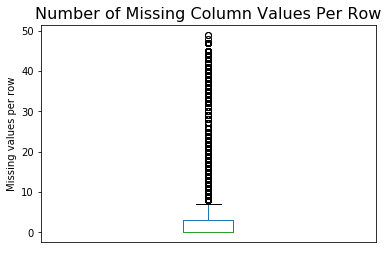

In [28]:
# Investigate patterns in the amount of missing data in each row
ax8, bp2 = number_missing_per_row.plot.box(return_type='both')

# Format axis
x_axis = ax8.axes.get_xaxis()
x_axis.set_visible(False)
ax8.set_title('Number of Missing Column Values Per Row', fontsize=16)
ax8.set(ylabel='Missing values per row');

In [29]:
# Remove the outlier columns from the dataset. 
outlier_missing_per_row = [flier.get_ydata() for flier in bp2["fliers"]]  # get outlier values from pd.boxplot
outlier_threshold = outlier_missing_per_row[0].min()  # threshold == smallest outlier value
print(f'Outlier number of missing values per row:\n{outlier_missing_per_row}')
print(f'\nThreshold for outlier number of missing values per row is {outlier_threshold}')

Outlier number of missing values per row:
[array([43, 47,  8, ..., 47, 47, 14], dtype=int64)]

Threshold for outlier number of missing values per row is 8


In [30]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# For diligence we will use two thresholds:
# 1: no missing data vs. at least one missing value
# 2: below outlier threshold missing vs. above threshold

df_no_missing = df.dropna()
df_with_missing = df[~df.index.isin(df_no_missing.index)]
print(f'Rows without missing values: {df_no_missing.shape[0]}')
print(f'Rows with missing values: {df_with_missing.shape[0]}')
print('---------------------------------------')

df_below_thr = df.dropna(thresh=(df.shape[1] - outlier_threshold))  # use outlier threshold from boxplot
df_above_thr = df[~df.index.isin(df_below_thr.index)]
print(f'Rows missing <{outlier_threshold} values: {df_below_thr.shape[0]}')
print(f'Rows missing >={outlier_threshold} values: {df_above_thr.shape[0]}')
print('---------------------------------------')

print(f'{(df_with_missing.shape[0] / df.shape[0] * 100):.2f}% of rows have at least one missing value')
print(f'{(df_above_thr.shape[0] / df.shape[0] * 100):.2f}% of rows with at least 8 missing values')


Rows without missing values: 623209
Rows with missing values: 268012
---------------------------------------
Rows missing <8 values: 771701
Rows missing >=8 values: 119520
---------------------------------------
30.07% of rows have at least one missing value
13.41% of rows with at least 8 missing values


In [31]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare_distributions(column, dfs, df_desc=[]):
    """Plots and compares distribution of values between for a given column between two (required) or three(optional)
       sets of data.
    
    Args:
        col (str): column name
        dfs ([pd.DataFrame]): list of datasets to be compared
        df_desc ([str]): optional descriptions of data sets for displaying over graphs
    """
    ncols = len(dfs)  # number of datasets to be compared
    
    fig, axes = plt.subplots(ncols=ncols, figsize=(15,3))
    fig.suptitle(f'Compare Distribution of Values in {column} For Rows Missing:')
    for idx, df in enumerate(dfs):
        percentage = lambda i: len(i) / float(len(x)) * 100
        sns.countplot(x=column, data=df, ax=axes[idx])
    
    # add titles for data set descriptions
    for ax, desc in zip(axes, df_desc):
        ax.set_title(desc);
    
    plt.subplots_adjust()
    plt.tight_layout(rect=[0, 0, 1, 0.95]);

In order to get an initial sense on the impact of missing values on our data, lets compare the distributions of values over classes for several columns for two pairs of data subsets: rows with no missing values vs. rows with at least one missing value; rows with less than 8 (our outlier missing threshold) missing values vs. rows with more than 8 missing values.

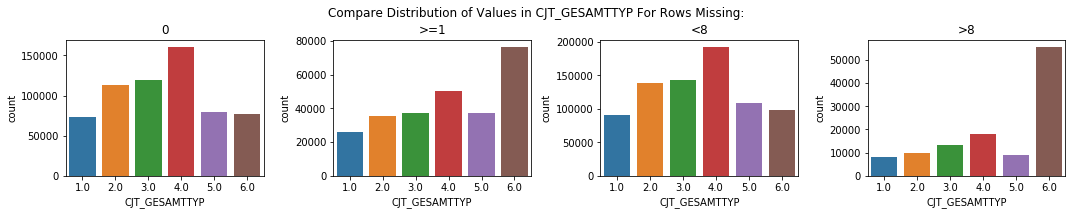

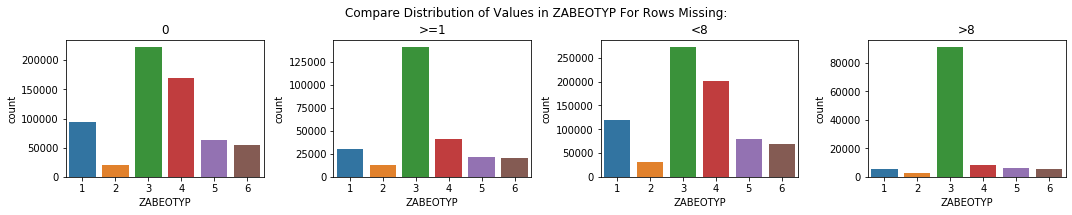

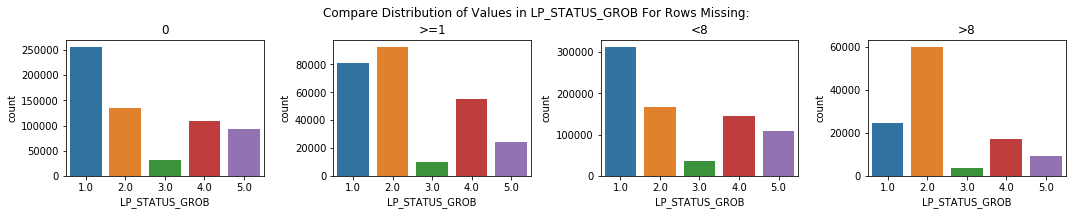

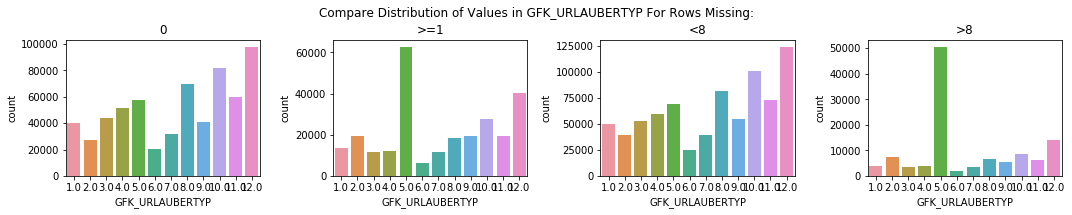

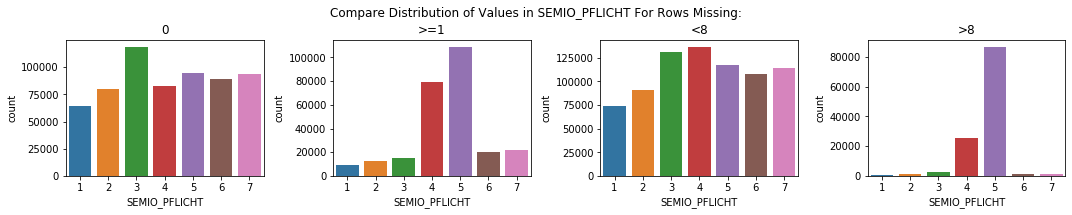

In [32]:
# select columns with less than 1% missing data:
low_missing_columns = percent_missing_per_column[percent_missing_per_column < 1]

# pick random columns for examination
random_cols = low_missing_columns.sample(5, random_state=0).index.values

# Compare distributions between row subsets
for col in random_cols:
    compare_distributions(column=col,
                          dfs=[df_no_missing, df_with_missing, df_below_thr, df_above_thr],
                          df_desc=['0', '>=1', '<8', '>8'])

Looking at the two pairs of row subsets: (no missing values vs. at least one missing value) and (<8 missing values vs. >=8 missing values) we see that the distributions of values on most columns are different between the above/below threshold subsets with at least one category level typically over-represented in a dataset with the above threshold number of missing values.  
  
Note that distribution of values over feature levels is quite similiar between data subsets containing rows with no missing values and subset containing rows with less than 8 missing values. Since we would like to lose as little of data as possible during the data cleaning step and over 30% of rows have at least one missing value, we will compromise and work with the dataset containing less than 8 missing values per row, retaining more than 85% of all rows for further analysis:

In [33]:
df_below_thr.shape  # subset data shape

(771701, 79)

In [34]:
df_below_thr.isna().sum().sum()  # total number of missing values in the selected data subset

662840

#### Discussion 1.1.3: Assess Missing Data in Each Row

##### Summary:
After initial data cleaning and removal of columns with outlier number of missing row values (column-wise), we examined the patterns of missing column values (row-wise). We found that 30.07% of rows have at least one missing value. Further inspection of the distribution of number of row-wise missing values shows that outlier number of missing column values is 8 with 13.41% of rows missing more than 8 column values.  
  
In order to understand whether missing data may have an impact on our analysis we qualitatively compared distribution of values over feature levels in 10 randomly chosen columns between rows with and without a large number of missing values. We found that while value distributions look similar between some columns, such as a group of `PLZX_XXX` columns, distributions in other columns, such as group of `SEMIO_XXX` can be quite dissimilar. Such columns where the distribution of values in rows with missing values is diffirent from non-missing data subset should be noted and treated with care. Deeper examination shows that subsets with large number of missing values typically have a category that is highly over-represented as compared with no missing data subset. This over-representation tells us that during data collection more information was gathered from some groups of people than others potentially biasing our analysis if this imbalance is not properly accounted for.

##### Data Selection, Cleaning and Encoding:
- Data Subset: `df_below_thr` is selected a subset of rows with < 8 missing values per row.

##### Output:
`df_below_thr` contains **771,701** rows and **79** columns with total of **662,840** missing values.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [35]:
# How many features are there of each data type?
print(f'Number of features for each data type is:\n{feat_info.type.value_counts()}')

Number of features for each data type is:
ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [36]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# list of names of categorical feautures
cat_cols = feat_info[feat_info.type == 'categorical']['attribute'].tolist()
# subset categorical features
df_cat = df_below_thr[[col for col in df_below_thr.columns if col in cat_cols]] 
df_cat_levels = df_cat.apply(pd.Series.nunique)
print(f'Number of unique levels in each categorical feature is:\n'
      f'{df_cat_levels}')  # number of unique values in each categorical column


Number of unique levels in each categorical feature is:
ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64


Note that `OS_WEST_KZ`, `CAMEO_DEU_2015`, and `CAMEO_DEUG_2015` features are encoded with non-numeric values. We can convert these to numerical values using Label Encoding.

In [37]:
def label_encode(df, columns, le_encoders={}):
    """Label Encode columns in the input data frame. If le_encoders dictionary is provided
    
    Args:
        df (pd.DataFrame): input dataframe
        columns ([str]): list of column names to be encoded
        le_encoders (dict): dictionary containing label encoders for the dataset.
                            If le_encoders is empty create new dictionary
                            - key: column name
                            - values: LabelEncoder 
        
    Returns:
        df_out (pd.DataFrame): output dataFrame with LabelEncoded columns
        le_encoders (dict): dictionary containing label encoders.
                            - key: column name
                            - values: LabelEncoder 
    """
    df_out = df.copy()
    
    for col in columns:
        # Subset column from DataFrame as Series
        series = df[col]
        
        # Instantiate encoder if it is not provided
        if col in le_encoders:
            encoder = le_encoders[col]
            pass  # do not fit encoder if it has already been provided
        else:
            encoder = LabelEncoder()  # instantiate LabelEncoder
            encoder.fit(series[series.notnull()])  # fit skipping missing
            le_encoders[col] = encoder  # add to le_encoders dictionary
        
        # Transform column 
        df_out[col] = pd.Series(encoder.transform(series[series.notnull()]),  
                                index=series[series.notnull()].index) # keep missing values in their places
        
    return df_out, le_encoders

**IMPORTANT**: We should fit Label Encoders on a dataset without any dropped rows rather than a subset with some rows dropped to ensure that all categories/classes are properly accounted for and some are not dropped with the dropped rows.

In [38]:
# Specify columns for Label Encoding
le_columns = ['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

# Fit Encoders on a full data set with no dropped rows
df_le, le_encoders = label_encode(df=df, columns=le_columns, le_encoders={})

# Label Encode working dataset while retaining le_encoders fitted on a full dataset
df_below_thr_le, _ = label_encode(df=df_below_thr, columns=le_columns, le_encoders=le_encoders)

In [92]:
# Examine LE dataframe
df_below_thr_le[le_columns].sample(5)

,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
632777,1,3.0,15.0
558501,1,2.0,11.0
240845,0,8.0,40.0
459987,1,2.0,11.0
840277,1,4.0,20.0


Note that during Label Encoding we have intentionally left missing values in place.

In [40]:
# Examine LE encoders
for col, encoder in le_encoders.items():
    print(f'{col} encoder classes: {encoder.classes_}')

OST_WEST_KZ encoder classes: ['O' 'W']
CAMEO_DEUG_2015 encoder classes: ['1' '2' '3' '4' '5' '6' '7' '8' '9']
CAMEO_DEU_2015 encoder classes: ['1A' '1B' '1C' '1D' '1E' '2A' '2B' '2C' '2D' '3A' '3B' '3C' '3D' '4A'
 '4B' '4C' '4D' '4E' '5A' '5B' '5C' '5D' '5E' '5F' '6A' '6B' '6C' '6D'
 '6E' '6F' '7A' '7B' '7C' '7D' '7E' '8A' '8B' '8C' '8D' '9A' '9B' '9C'
 '9D' '9E']


Now we can leave the binary categorical features alone and OneHotEncode the remaining multi-level features.

In [41]:
binary_cat_cols = df_cat_levels[df_cat_levels <= 2].index.tolist()
print(f'{len(binary_cat_cols)} binary-level columns: {binary_cat_cols}')

5 binary-level columns: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']


In [42]:
# Re-encode categorical variable(s) to be kept in the analysis.

# column names of mutli-level categorical features
multi_cat_cols = df_cat_levels[df_cat_levels > 2].index.tolist()
print(f'{len(multi_cat_cols)} multi-level columns: {multi_cat_cols}')

13 multi-level columns: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [43]:
def one_hot_encode(df, columns=[], oh_encoders={}):
    """Replaces input df[columns] with One Hot Encoded columns using sklearn.preprocessing.OneHotEncoder.
       OHE output columns are named using schema: [source_column_name]_[encoder_category_]
       Missing values in the source column will be encoded in the col_9999.
    
    Args:
        df (pd.DataFrame): input dataframe
        columns ([str]): list of column names to be encoded
        oh_encoders (dict): dictionary containing OneHotEncoder(s) for the dataset.
                            If oh_encoders is empty create new dictionary
                            - key: column name
                            - values: OneHotEncoder 
        
    Returns:
        df_out (pd.DataFrame): output dataFrame with LabelEncoded columns
        ohe_encoders (dict): dictionary containing label encoders.
                             - key: column name
                             - values: LabelEncoder
    """
    # copy df to df_out with reset indexing
    # reset_index is necessary to correctly concatenate OHE columns if any rows where dropped from input df
    df_out = df.reset_index(drop=True)  
    
    for col in columns:
        # Subset column from DataFrame as Series
        series = df[col]
        
        # replace np.nan with 9999 to allow encoding of missing values
        series = series.fillna(9999)
        
        # Instantiate encoder if it is not provided
        if col in oh_encoders:
            encoder = oh_encoders[col]
            pass  # Do not fit if encoder is already provided
        else:
            # instantiate new encoder
            encoder = OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore')  
            # Fit, reshaping single column (-1, 1), since OHE expects 2D array
            encoder.fit(series.to_numpy().reshape(-1, 1))
            oh_encoders[col] = encoder  # add to oh_encoders dictionary

        # Generate new column names for OHE encoded columns
        # 'XXX_9999' column stores information on which source data rows were missing values
        col_names = ['_'.join([col, str(int(cat))]) for cat in encoder.categories_[0]]
        
        # Transform and return as pd.dataFrame
        ohe_out = pd.DataFrame(encoder.transform(series.to_numpy().reshape(-1, 1)), columns=col_names)
        
        # Drop source column from output dataframe
        df_out = df_out.drop(columns=[col])
        
        # Add new one hot encoded columns to df_out
        df_out = pd.concat([df_out, ohe_out], axis=1)
    
    return df_out, oh_encoders

**IMPORTANT**: As above with Label Encoding, we should fit One Hot Encoders on a full dataset rather than a subset with some rows dropped to ensure that all categories/classes are properly accounted for. Additionally, we should perform OHE on Label Encoded Dataset.

In [44]:
# One Hot Encode Multi-level columns
oh_columns = multi_cat_cols

# Fit Encoders on the data set with no dropped rows that has been label encoded
_, oh_encoders = one_hot_encode(df=df_le, columns=oh_columns, oh_encoders={})

# One Hot Encode working dataset while retaining oh_encoders fitted on a full dataset
df_below_thr_ohe, _ = one_hot_encode(df=df_below_thr_le, columns=oh_columns, oh_encoders=oh_encoders)

Lets look at our encoded dataframe:

In [93]:
df_below_thr_ohe.sample(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_39,CAMEO_DEU_2015_40,CAMEO_DEU_2015_41,CAMEO_DEU_2015_42,CAMEO_DEU_2015_43,CAMEO_DEU_2015_9999,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage
351407,4.0,1,4,1,5,1,1,5,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,4.0,5.0
757495,3.0,2,3,2,4,3,3,4,0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,2.0,3.0
89767,4.0,2,2,1,5,1,1,5,0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,5.0,5.0
364769,2.0,2,1,4,1,5,3,4,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,4.0,5.0
360149,2.0,1,2,5,1,2,5,3,0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,5.0,4.0


In [46]:
df_below_thr_ohe.shape

(771701, 205)

In [47]:
df_below_thr_ohe.isna().sum().sum()  # NAN values

546273

In [48]:
print(df_below_thr_ohe.filter(regex='_9999').sum())  # missing values in One Hot Encoded columns
print('Total missing in OHE colums:', df_below_thr_ohe.filter(regex='_9999').sum().sum())

CJT_GESAMTTYP_9999           0.0
GFK_URLAUBERTYP_9999         0.0
LP_FAMILIE_FEIN_9999     23698.0
LP_FAMILIE_GROB_9999     23698.0
LP_STATUS_FEIN_9999          0.0
LP_STATUS_GROB_9999          0.0
NATIONALITAET_KZ_9999    30005.0
SHOPPER_TYP_9999         32488.0
GEBAEUDETYP_9999             0.0
CAMEO_DEUG_2015_9999      3339.0
CAMEO_DEU_2015_9999       3339.0
dtype: float64
Total missing in OHE colums: 116567.0


#### Discussion 1.2.1: Re-Encode Categorical Features

We have examined categorical features and determined that features encoded as strings require numeric re-encoding for further analysis. These features were re-encoded by either direct value replacement or Label Encoding. Additionaly, multi-level features were one-hot-encoded to allow use with standard sklearn predictors.   

##### Summary:
The dataset contains 18 categorical features:
- 5 binary:: `'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ'`
- 13 multi-level: `'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'`  
  
##### Transformations and Encodings:
- **Label Encoding**: `OST_WEST_KZ`, `CAMEO_DEU_2015` and `CAMEO_DEUG_2015` features were  label encoded with sklearn.preprocessing.LabelEncoder. List of label encoded columns is stored in `le_columns`. Encoders saved as dictionary `le_encoders`.
- **One Hot Encoding**: all 13 multi-level categorical features were one hot encoded using sklearn.preprocessing.LabelEncoder. List of one-hot encoded source columns is stored in `oh_columns`. Encoders saved as dictionary `oh_encoders`. 

##### Output:
- Data subset with categorical one-hot-encoded features **`df_below_thr_ohe`** has **771,701** rows and **205** columns with **546,273** total NAN values. Additionally, there are **116,567** missing values in one-hot-encoded columns stored in the `XXX_9999` named columns as 1.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [49]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Using Data_Dictionary.md define new feature 'PRAEGENDE_JUGENDJAHRE_decade' 
# that indicates generation by decade:
# np.nan: missing
# 1: 40s
# 2: 50s
# 3: 60s
# 4: 70s
# 5: 80s
# 6: 90s
df_below_thr_ohe['PRAEGENDE_JUGENDJAHRE_decade'] = df_below_thr_ohe['PRAEGENDE_JUGENDJAHRE'].apply(
        lambda x: (x if np.isnan(x)
                   else 1 if x <= 2
                   else 2 if x <= 4
                   else 3 if x <= 7 
                   else 4 if x <= 9
                   else 5 if x <= 13
                   else 6))
# Define new feature 'PRAEGENDE_JUGENDJAHRE_movement' that indicates generation by decade:
# np.nan: missing
# 1: Mainstream
# 2: Avantgarde
df_below_thr_ohe['PRAEGENDE_JUGENDJAHRE_movement'] = df_below_thr_ohe['PRAEGENDE_JUGENDJAHRE'].apply(
        lambda x: (x if np.isnan(x)
                   else 1 if x in [1., 3., 5., 8., 10., 12., 14.]
                   else 2))

Lets see how our two new features look like:

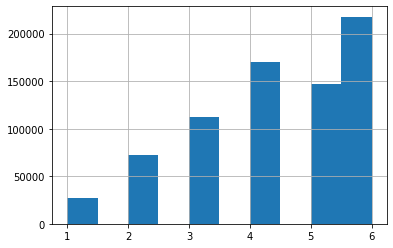

In [50]:
df_below_thr_ohe['PRAEGENDE_JUGENDJAHRE_decade'].hist();

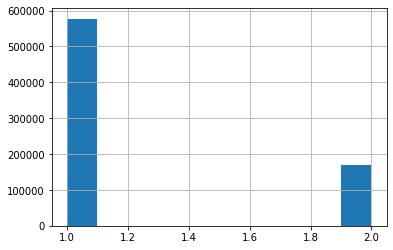

In [51]:
df_below_thr_ohe['PRAEGENDE_JUGENDJAHRE_movement'].hist();

In [52]:
df_below_thr_ohe[['PRAEGENDE_JUGENDJAHRE', 'PRAEGENDE_JUGENDJAHRE_decade',
                  'PRAEGENDE_JUGENDJAHRE_movement']].sample(5)

,PRAEGENDE_JUGENDJAHRE,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement
48841,3.0,2.0,1.0
553503,15.0,6.0,2.0
436975,3.0,2.0,1.0
705996,14.0,6.0,1.0
148467,10.0,5.0,1.0


Lets drop the source feature for the two new features to eliminate redundancy:

In [53]:
df_below_thr_ohe = df_below_thr_ohe.drop(columns=['PRAEGENDE_JUGENDJAHRE'])
# IMPORTANT: do not update drop_columns list, since this feature cannot be dropped prior to re-engineering.
# PRAEGENDE_JUGENDJAHRE must be dropped as part of feature re-engineering task

In [54]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Define new feature 'CAMEO_INTL_2015_wealth' that stores the wealth category (1st digit of 'CAMEO_INTL_2015)
df_below_thr_ohe['CAMEO_INTL_2015_wealth'] = df_below_thr_ohe['CAMEO_INTL_2015'].astype(float).apply(
        lambda x: (x if np.isnan(x) else int(x) // 10 % 10))

# Define new feature 'CAMEO_INTL_2015_life_stage' that stores the life stage category (2nd digit of 'CAMEO_INTL_2015)
df_below_thr_ohe['CAMEO_INTL_2015_life_stage'] = df_below_thr_ohe['CAMEO_INTL_2015'].astype(float).apply(
        lambda x: (x if np.isnan(x) else int(x) % 10))

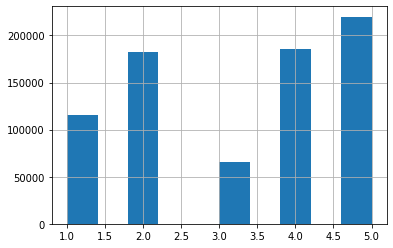

In [55]:
df_below_thr_ohe['CAMEO_INTL_2015_wealth'].hist();

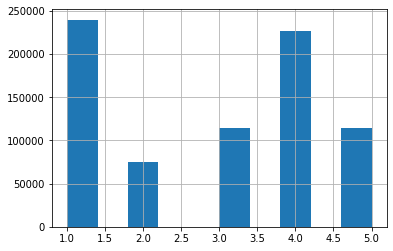

In [56]:
df_below_thr_ohe['CAMEO_INTL_2015_life_stage'].hist();

In [57]:
df_below_thr_ohe[['CAMEO_INTL_2015', 'CAMEO_INTL_2015_wealth',
                  'CAMEO_INTL_2015_life_stage']].sample(5)

,CAMEO_INTL_2015,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage
367844,14,1.0,4.0
739654,51,5.0,1.0
150420,13,1.0,3.0
176148,24,2.0,4.0
715723,25,2.0,5.0


Again, we drop the source column for our engineered columns to avoid redundancy.

In [58]:
df_below_thr_ohe = df_below_thr_ohe.drop(columns=['CAMEO_INTL_2015'])
# IMPORTANT: do not update drop_columns list, since this feature cannot be dropped prior to re-engineering.
# CAMEO_INTL_2015 must be dropped as part of feature re-engineering task

Now, lets investigate other mixed features.

In [59]:
# Investigate other mixed features
mixed_features = feat_info[feat_info.type == 'mixed']
mixed_features

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


`LP_LEBENSPHASE_FEIN` and `LP_LEBENSPHASE_GROB` mixed features combine **redundant** information about wealth, life stage, and household type already contained in the `LP_FAMILIE_GROB`, `LP_STATUS_FEIN`, `LP_STATUS_GROB`, as well as `CAMEO_INTL_2015` features. Thus, we will drop these columns from further analysis.

In [60]:
# drop columns with redundant info
df_below_thr_ohe = df_below_thr_ohe.drop(columns=['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'])
# update list containing dropped column names
drop_columns.extend(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'])

`WOHNLAGE` feature category levels are mixed with 5 levels indicating the quality of the neighborhood and 2 containing a rural neighborhood flag. Since neighborhood quality is also described in the `REGIOTYP` feature, *Rural Neighborhood* is one of the classes of `CAMEO_DEU_2015` feature, and there is not enough information across categories to engineer new features, we will drop `WOHNLAGE` feature from further analysis.

In [61]:
df_below_thr_ohe = df_below_thr_ohe.drop(columns=['WOHNLAGE'])  # drop columns with redundant info
drop_columns.extend(['WOHNLAGE'])  # update list containing dropped column names

We will leave the ramining mixed columns as is for further analysis. Lets examine our new dataframe 

In [62]:
df_below_thr_ohe.shape

(771701, 204)

In [63]:
df_below_thr_ohe.isna().sum().sum()  # NAN count

495129

In [64]:
df_below_thr_ohe.filter(regex='_9999').sum().sum()  # OHE column missing count

116567.0

#### Discussion 1.2.2: Engineer Mixed-Type Features

##### Summary:
We have examined categorical mixed type features and found that some contain information redundant to other features in the dataset and dropped these columns. Two columns contained a combination of two unrelated properties each and were re-engineered to split these properties into separate features.

##### Mixed-Type Feture Selection and Re-Engineering:
- **Dropped**: `LP_LEBENSPHASE_FEIN`, `LP_LEBENSPHASE_GROB`, `WOHNLAGE`, `PRAEGENDE_JUGENDJAHRE` (see below), `CAMEO_INTL_2015` (see below)
- **Re-engineered**:
    - `PRAEGENDE_JUGENDJAHRE` ==> `PRAEGENDE_JUGENDJAHRE_decade` (6 levels), `PRAEGENDE_JUGENDJAHRE_movement` (2 levels)
    - `CAMEO_INTL_2015` ==>  `CAMEO_INTL_2015_wealth` (5 levels), `CAMEO_INTL_2015_life_stage` (5 levels)
- **Retained**: `KBA05_BAUMAX`, `PLZ8_BAUMAX`

##### Output:
- Data subset with categorical one-hot-encoded and re-engineered mixed features, **`df`**, has **771,701** rows and **204** columns with **598,301** NAN missing values and **321,971** OHE encoded missing values as 1 in `XXX_9999` columns.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [65]:
def clean_data(df, feat_info, 
               drop_columns=[], missing_threshold=0, 
               le_columns=[], le_encoders={},
               oh_columns=[], oh_encoders={}):
    """Performs feature trimming, re-encoding, and engineering for demographics
       data.
    
    Args:
        df (pd.DataFrame): input demographics DataFrame
        feat_info (dict): feature summary that contains the following columns/information:
                                  - attribute (str): df column name
                                  - missing_or_unknown (str): information on how missing values
                                    are encoded in each column
        drop_columns([str]): list of column names to drop
        missing_threshold (int): maximum number of missing values per row
        le_columns ([str]): list of names for columns that require Label Encoding
        le_encoders (dict): dictionary containing label encoders for the dataset.
                            If le_encoders is empty look at le_columns to see if LE is needed
                            If le_encoders is empty and LE is needed create new dictionary
                            - key: column name
                            - values: LabelEncoder
        oh_columns ([str]): list of names for columns that require One Hot Encoding.
        oh_encoders (dict): dictionary containing OneHotEncoder(s) for the dataset.
                            If oh_encoders is empty look at oh_columns to see if OHE is needed
                            If oh_encoders is empty and OHE is needed create new dictionary
                            - key: column name
                            - values: OneHotEncoder
                            
    Returns:
        df_out (pd.DataFrame): Trimmed and cleaned demographics DataFrame
        le_encoders (dict)
        oh_encoders (dict)
    """
    # Convert missing value codes into NaNs, ...
    df_out = encode_nan(df=df, feat_info=feat_info)
        
    # Drop columns
    df_out = df_out.drop(columns=drop_columns)
    
    # Drop rows containing more than threshold number of missing values
    df_out = df_out.dropna(thresh=(df_out.shape[1] - missing_threshold), axis=0)
    
    # Label encode columns found in le_encoders keys
    if le_columns:
        df_out, le_econders = label_encode(df=df_out, columns=le_columns, le_encoders=le_encoders)

    # One-hot-encode columns found in oh_encoders keys
    if oh_columns:
        df_out, oh_encoders = one_hot_encode(df=df_out, columns=oh_columns, oh_encoders=oh_encoders)
    
    # Manually engineer features:
    
    # Using Data_Dictionary.md define new feature 'PRAEGENDE_JUGENDJAHRE_decade'
    # that indicates generation by decade:
    # np.nan: missing
    # 1: 40s
    # 2: 50s
    # 3: 60s
    # 4: 70s
    # 5: 80s
    # 6: 90s
    df_out['PRAEGENDE_JUGENDJAHRE_decade'] = df_out['PRAEGENDE_JUGENDJAHRE'].apply(
            lambda x: (x if np.isnan(x)
                       else 1 if x <= 2
                       else 2 if x <= 4
                       else 3 if x <= 7 
                       else 4 if x <= 9
                       else 5 if x <= 13
                       else 6))
    # Define new feature 'PRAEGENDE_JUGENDJAHRE_movement' that indicates generation by decade:
    # np.nan: missing
    # 1: Mainstream
    # 2: Avantgarde
    df_out['PRAEGENDE_JUGENDJAHRE_movement'] = df_out['PRAEGENDE_JUGENDJAHRE'].apply(
            lambda x: (x if np.isnan(x)
                       else 1 if x in [1., 3., 5., 8., 10., 12., 14.]
                       else 2))
    df_out = df_out.drop(columns=['PRAEGENDE_JUGENDJAHRE'])
    
    # Define new feature 'CAMEO_INTL_2015_wealth' that stores the wealth category
    # (1st digit of 'CAMEO_INTL_2015)
    df_out['CAMEO_INTL_2015_wealth'] = df_out['CAMEO_INTL_2015'].astype(float).apply(
            lambda x: (x if np.isnan(x) else int(x) // 10 % 10))
    # Define new feature 'CAMEO_INTL_2015_life_stage' that stores the life stage category
    # (2nd digit of 'CAMEO_INTL_2015)
    df_out['CAMEO_INTL_2015_life_stage'] = df_out['CAMEO_INTL_2015'].astype(float).apply(
            lambda x: (x if np.isnan(x) else int(x) % 10))
    df_out = df_out.drop(columns=['CAMEO_INTL_2015'])
    
    # Return the cleaned dataframe.
    return df_out, le_encoders, oh_encoders
    

**IMPORTANT**: 
In order to achieve repeatable results, we will use Label and One Hot encoders fitted on data without any dropped rows, ensuring that all original encoding categories are preserved.

Lets test out our `clean_data` function and play with the `missing_threshold` parameter to see if we can reduce the number of missing values without drastically reducing the size of the data set. We will use the lists for dropped columns (`drop_columns`) and columns requiring label (`le_columns`) and one-hot encoding (`oh_columns`) from our analysis above.

In [66]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# perform automated cleaning and encoding
thresholds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 15, 20, 25]
percent_missing_vs_thr = []
missing_vs_thr = []
rows_vs_thr = []
for thr in thresholds:
    # Perform data cleaning
    df_thr, _, _ = clean_data(df=azdias, feat_info=feat_info,
                             drop_columns=drop_columns, missing_threshold=thr,
                             le_columns=le_columns, le_encoders=le_encoders,
                             oh_columns=oh_columns, oh_encoders=oh_encoders)
    num_missing = df_thr.isna().sum().sum() + df_thr.filter(regex='_9999').sum().sum()
    rows = len(df_thr.index)
    
    missing_vs_thr.append(num_missing)
    percent_missing_vs_thr.append(100 * num_missing / (df_thr.shape[0] * df_thr.shape[1]))
    rows_vs_thr.append(rows)

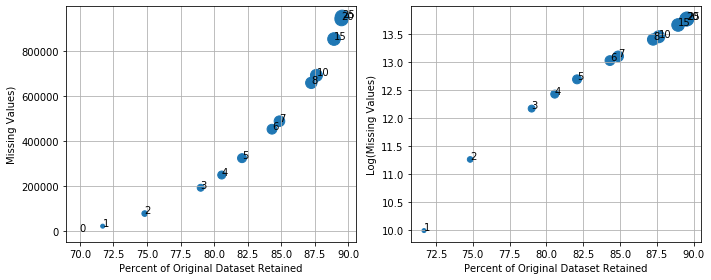

In [85]:
fig, (ax9, ax10) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

# Percent of original dataset number of rows
percent_retained_rows = [x / len(azdias.index) * 100 for x in rows_vs_thr]

# Log of the number of missing values
log_missing = [np.log(y + 1) for y in missing_vs_thr]

# marker size proportional to missing per row threshold
s = [n * 16 for n in range(len(thresholds))]  

ax9.scatter(percent_retained_rows, missing_vs_thr, s=s)
ax10.scatter(percent_retained_rows[1:], log_missing[1:], s=s[1:])  # zoom of ax9 graph

# Label points with missing per row threshold values
for i, txt in enumerate(thresholds):
    ax9.annotate(txt, (percent_retained_rows[i], missing_vs_thr[i]))
for i, txt in enumerate(thresholds[1:]):
    ax10.annotate(txt, (percent_retained_rows[i + 1], log_missing[i + 1]))
    
ax9.set_xlabel('Percent of Original Dataset Retained')
ax10.set_xlabel('Percent of Original Dataset Retained')
ax9.set_ylabel('Missing Values)')
ax10.set_ylabel('Log(Missing Values)')
ax9.grid(axis='both')
ax10.grid(axis='both');
plt.tight_layout()

From graphs above (linear-scale on the left and log-scale on the right) we can see that the the number of missing values increases exponentially with the number of retained rows. So we have to be careful when choosing our missing-per-row threshold.

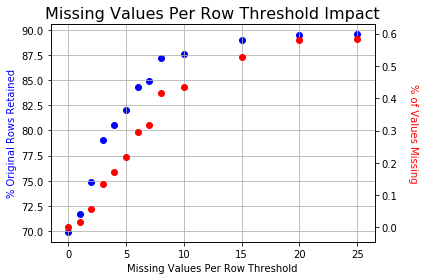

In [71]:
x = thresholds
y11 = percent_retained_rows
y12 = percent_missing_vs_thr

fig, ax11 = plt.subplots()
ax11.set_title('Missing Values Per Row Threshold Impact', fontsize=16)
ax11.set_ylabel('% Original Rows Retained', color='blue')
ax11.scatter(x, y11, color='blue')
ax12 = ax11.twinx()
ax11.set_xlabel('Missing Values Per Row Threshold')
ax12.set_ylabel('% of Values Missing', rotation=270, labelpad=20, color='red')
ax12.scatter(x, y12, color='red')
ax11.grid(axis='both')
fig.tight_layout();

Looking at the graph showing the impact of number of missing values per row threshold on our decision to drop rows with `pd.dropna(thresh=)`, we see that our original thought of retaining only rows containing less than 8 missing values was a good one since we see that the number of retained rows starts to saturate for threshold above 8. This implies that little additional information will be provided by the rows with larger numbers of missing values. Thus, for now we will stick with this cutoff point ensuring that we have retained **over 85%** of original rows with **less than 0.5%** of missing values.

In [90]:
missing_per_row_threshold = 8
data, _, _ = clean_data(df=azdias, feat_info=feat_info,
                        drop_columns=drop_columns, missing_threshold=missing_per_row_threshold,
                        le_columns=le_columns, le_encoders=le_encoders,
                        oh_columns=oh_columns, oh_encoders=oh_encoders)

In [91]:
print(f'Clean data shape: {data.shape}; NaN count: {data.isnull().sum().sum()}; '
      f'OHE Missing: {data.filter(regex="_9999").sum().sum()}')

Clean data shape: (777557, 204); NaN count: 512854; OHE Missing: 145932.0


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [105]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [106]:
data_scaled.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_39,CAMEO_DEU_2015_40,CAMEO_DEU_2015_41,CAMEO_DEU_2015_42,CAMEO_DEU_2015_43,CAMEO_DEU_2015_9999,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage
count,7.749590e+05,7.775570e+05,7.775570e+05,7.775570e+05,7.775570e+05,7.775570e+05,7.775570e+05,7.775570e+05,7.775570e+05,7.432420e+05,...,7.775570e+05,7.775570e+05,7.775570e+05,7.775570e+05,7.775570e+05,7.775570e+05,7.520980e+05,7.520980e+05,7.741250e+05,7.741250e+05
mean,-1.762466e-15,-1.672907e-14,-3.027812e-15,-6.239037e-15,7.603323e-15,6.722686e-15,3.453178e-15,-2.800939e-14,-9.100041e-15,7.106747e-16,...,-5.064966e-15,3.637438e-15,-3.275042e-15,-5.950057e-15,3.943739e-15,1.724574e-14,3.546872e-15,3.198014e-14,-3.289506e-15,-8.905368e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.763254e+00,-1.043207e+00,-1.486526e+00,-1.152504e+00,-1.770681e+00,-1.248888e+00,-1.171709e+00,-1.535045e+00,-5.317983e-01,-1.595020e+00,...,-1.640024e-01,-1.913915e-01,-1.816338e-01,-1.945678e-01,-8.817696e-02,-6.658373e-02,-2.278267e+00,-5.433313e-01,-1.553172e+00,-1.256434e+00
25%,-7.817804e-01,-1.043207e+00,-7.608932e-01,-1.152504e+00,-1.044322e+00,-1.248888e+00,-1.171709e+00,-8.197424e-01,-5.317983e-01,-2.708321e-01,...,-1.640024e-01,-1.913915e-01,-1.816338e-01,-1.945678e-01,-8.817696e-02,-6.658373e-02,-9.071136e-01,-5.433313e-01,-8.707292e-01,-1.256434e+00
50%,1.996929e-01,9.585822e-01,-3.525992e-02,1.925764e-01,4.083983e-01,1.087573e-01,-4.543392e-01,-1.044403e-01,-5.317983e-01,-2.708321e-01,...,-1.640024e-01,-1.913915e-01,-1.816338e-01,-1.945678e-01,-8.817696e-02,-6.658373e-02,-2.215372e-01,-5.433313e-01,4.941572e-01,8.752836e-02
75%,1.181166e+00,9.585822e-01,6.903733e-01,8.651167e-01,1.134758e+00,7.875797e-01,9.804010e-01,6.108619e-01,-5.317983e-01,1.053356e+00,...,-1.640024e-01,-1.913915e-01,-1.816338e-01,-1.945678e-01,-8.817696e-02,-6.658373e-02,1.149616e+00,-5.433313e-01,1.176600e+00,7.595097e-01
max,1.181166e+00,9.585822e-01,1.416007e+00,1.537657e+00,1.134758e+00,1.466402e+00,1.697771e+00,1.326164e+00,1.880412e+00,1.053356e+00,...,6.097473e+00,5.224892e+00,5.505583e+00,5.139596e+00,1.134083e+01,1.501868e+01,1.149616e+00,1.840498e+00,1.176600e+00,1.431491e+00


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [73]:
# Apply PCA to the data.



In [74]:
# Investigate the variance accounted for by each principal component.



In [75]:
# Re-apply PCA to the data while selecting for number of components to retain.



### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [76]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.



In [77]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.



In [78]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.



### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [79]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

In [80]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



In [81]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.



### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [82]:
# Load in the customer demographics data.
customers = 

SyntaxError: invalid syntax (<ipython-input-82-416d584d1460>, line 2)

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.